In [190]:
from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy as sp 
from scipy.optimize import minimize
from threading import Thread

# Risk Constrained Portfolio Optimizer

Hello! This is a capital-preservation focused portfolio construction system where the user can can generate a portfolio of equities that aproximates risk-free. The user can give a CSV of tickers they want to choose from. In the end a final dataframe of the portfolio will be displayed and a CSV will be outputted. Keep in mind that the purchases of the shares will be using the **last full trading day's closing price.**

There are also many other variables that can be configured such as, but not limited to, sector diversification requirements, share purchasing fee requirements, budget requirements, dates for analysis, etc. 

**Run-time Note:** The code performed on a CSV of 509 tickers (some of which invalid) and ran in less than 90 seconds. 

<hr>

The base code was originally for a Group Competition from my CFM 101 course where teams competed to create a Risk-Free stock picker. But in here I have indepdently repurposed and optimized it. It is signficantly faster, and more configurable. If you wish to see the original code please reach out.

Throughout this Jupyter file there will be explanations for our code, please keep in mind the majority of the markdowns were originally for the TA's reading then. 

<hr>

**Update!** Our team got 100% on our assignment and recieved full marks in the competition!

## Configurable Variables
Below are all the global variables that can be configured. Please do not touch anything elsewhere if you want to configure a setting. 

In [191]:
# CSV Ticker file path
csv_file_path = "Sample_Tickers.csv"

# Date ranges used to analyze the percent returns of stocks
returns_start = "2024-11-14" 
returns_end = "2025-11-14" 

# Date ranges used to determine volume 
vol_start = "2024-10-01"
vol_end = "2025-10-01"

# Volume filtering
min_avg_vol = 5000
min_trading_days_per_month = 18

# Portfolio size constraints
min_port_size = 15
max_port_size = 25

# Market cap constraints (in USD)
small_cap_threshold = 2_000_000_000
large_cap_threshold = 10_000_000_000

# Weight constraints (per stock)
min_weight = None # Later will be set to the formula: (100/(2*num_assets))/100
max_weight = 0.15

# Sector constraints
max_sector_weight = 0.40

# Budget
total_budget = 1_000_000

# Fee structure
flat_fee_cad = 2.5
variable_fee_per_share = 0.001

# Max iterations when trying to create a succesful portfolio
max_iterations = 20

# Risk Free rate used to calculate Sharpe Ratio
risk_free_rate = 1 # is 1%, keep as full number not decimal form

## Input Filtering

The following code will read in `csv_file_path` and then perform filtration. The primary goal is to remove any duplicate tickers, any non US or Canadian companies, and any stocks that don’t trade the `min_avg_vol` between the `vol_start` and `vol_end` date. 
<hr>

### Preliminary Filtering
Using the *`valid_tickers()`* function we can do a preliminary filtration by:

- Using pandas to read in the csv, fixing any leading spaces, and then drop any duplicates tickers
- Downloading all the ticker information using *`yfinance.download()`* between `min_avg_vol` and `vol_start` 
- Manipulating the dataframe to remove any months that trade less than the user set `min_trading_days_per_month`, and removing stocks that don’t meet our `min_avg_vol` constraint 

In [192]:
def valid_tickers(csv_file_path):
   """
   valid_tickers is the prelimary checker, it reads a csv and then removes any tickers that trade less than the minimum volume

   :param csv_file_path: A string that represents the csv file name that will be read
   :return: A list of names of the valid tickers
   """
   
   print(f"Now loading tickers from {csv_file_path}.")

   # Scrape for unique tickers
   try:
      tickers_df = pd.read_csv(csv_file_path, header=None)
      tickers_df.columns = ["Ticker"]
      tickers_df["Ticker"] = tickers_df["Ticker"].str.strip()
      tickers_df = tickers_df.drop_duplicates()
      ticker_list = tickers_df["Ticker"].tolist()

      print(f"{len(ticker_list)} unique tickers have been found in the csv. Now downloading tickers.")
   except FileNotFoundError:
      raise FileNotFoundError(f"Could not find file path to {csv_file_path}.")

   # Bulk download the ticker information
   hist = yf.download(
       tickers=ticker_list,
       start=vol_start,
       end=vol_end,
       group_by="ticker",
       auto_adjust=False,
       threads=True,
       progress=False
    )
   
   if hist.empty:
      raise ValueError("No data downloaded, check ticker symbols and date range.")

   # Count the rows per month per ticker
   trading_days_per_month = hist.groupby(hist.index.to_period("M")).transform("count")

   # Keep only rows where all tickers in that month exceed configured minimum
   valid_days_mask = trading_days_per_month >= min_trading_days_per_month
   hist_filtered = hist[valid_days_mask]

   # Remove the months that do not meet threshold and any tickers that don't have a large enough trading volume
   vol_filtered = hist_filtered.xs("Volume", axis=1, level=1)
   avg_vol_filtered = vol_filtered.mean()
   valid_tickers = avg_vol_filtered[avg_vol_filtered >= min_avg_vol].index.tolist()

   return valid_tickers

### Secondary Filtering

Now that we have a list of tickers that have passed our preliminary filtering, we want to remove any non US or Canadian companies.

But since we need to use yfinance's *`info()`* function, this function is quite slow. Thus to reduce runtime we have decided to thread the secondary filtering, which is:

- Using *`info()`* to get the `Currency` of a stock and if it isn’t traded in `CAD` or `USD` then return NaN
- We keep track of each valid ticker’s `Currency`, `Sector`, and `MarketCap`, all information that will be useful later

In the end we keep track of this information in `Dataframe` which is returned.

In [193]:
#Begin threading set up
def get_format_info(ticker, ticker_data):
   """
   get_format_info is the threading worker function, it is what will be done in parallel. It finds wanted ticker info
   and adds it to a list

   :param ticker: The ticker whose info is wanted
   :param ticker_data: A list that keeps track of the ticker info thats been extracted
   """
   try:
      ticker_info = yf.Ticker(ticker).info

      # Check currency
      currency = ticker_info.get("currency")
      if (currency not in ["CAD", "USD"]):
         return
      
      # Check if its an equity
      if ticker_info.get("quoteType") != "EQUITY": 
         return
      
      ticker_data.append((
            ticker,
            ticker_info.get("sector"),
            currency,
            ticker_info.get("marketCap")))
      
   except:
      pass

#Threading occurs
def format_tickers(csv_file_path):
   """
   format_tickers is the main function that performs threading onto the worker function and gets the dataframe of tickers and wanted info

   :param csv_file_path: A string that represents the csv file name that will be read
   :return: A Dataframe that contains all the info we want for every valid ticker
   """
   ticker_list = valid_tickers(csv_file_path)

   print(f"Fetching info for {len(ticker_list)} tickers.")
   
   # Threading for parallel API calls
   ticker_data = []
   threads = []

   # Loop and create threads of each ticker in the ticker_list
   for t in ticker_list:
      thread = Thread(target=get_format_info, args=(t, ticker_data))
      threads.append(thread)
      thread.start()

   # Once all threads complete, join them together 
   for th in threads:
      th.join()

   # Create and clean up the Dataframe
   ticker_df = pd.DataFrame(ticker_data, columns=["Ticker","Sector","Currency","MarketCap"]) 
   ticker_df = ticker_df.dropna(subset=["Sector", "MarketCap"])
   ticker_df = ticker_df.reset_index(drop=True)

   print(f"{len(ticker_df)} tickers with complete information found.")

   return ticker_df

## Info Extraction

Now armed with the valid tickers, info extraction can be done. The most important thing to consider are the price movements of each stock, but since the period that will be considered is quite long, keeping track of daily data is both memory-intensive and not properly representative. What’s more important is how stocks behave weekly. 

The code below will find the weekly prices and weekly price percent changes of each stock. Using that information the following information can be obtained: `Variance`, `Standard Deviation`,  `Covariance Matrix`, and `Correlation Matrix`,

Recall that our strategy is to obtain a ***Risk-Free Portfolio***, which means we want a portfolio whose value does not move. In other words, absolutely no volatility, absolutely no concentration, absolutely no risk, and complete diversification. Those 4 metrics will help it comes to crafting such a portfolio as:

- `Variance` tells us how volatile a stock’s returns are from its mean return
- `Standard Deviation` also tells us how volatile a stock is
- A `Covariance Matrix` tells us how the variance between two assets correlate, giving us information on how to match different stocks together to minimize volatility
- A `Correlation Matrix` shows the strength of the relationship between two assets movements 

In [194]:
# Gets weekly closes of all the stocks in a list of tickers
def get_weekly_closes (ticker_list):
    """     
    get_weekly_closes performs data extraction to get weekly closing price info of stocks

    :param ticker_lst: List that holds all tickers
    :return: returns a Dataframe that holds the weekly closing price of each ticker on every week
    """
    print(f"Downloading price data for {len(ticker_list)} tickers.")

    price_hist = yf.download(
        tickers=ticker_list,
        start=returns_start,
        end=returns_end,
        group_by="ticker",
        auto_adjust=True,
        threads=True,
        progress=False,
        multi_level_index=False
    )

    if price_hist.empty:
        raise ValueError("No data downloaded, check date range and tickers.")
    
    # yf.download handles single ticker and multiple ticker download cases differently
    if len(ticker_list) == 1:
        close_data = price_hist[["Close"]]
        close_data.columns = ticker_list
    else:
        close_data = price_hist.xs('Close', axis=1, level=1)

    # Reorder
    close_data = close_data[ticker_list]

    # Get the weekly closing price, and then clean the index
    weekly_closes = close_data.resample("W-FRI").last()
    weekly_closes.index = weekly_closes.index.strftime('%Y-%m-%d')

    print(f"Completed download of {len(weekly_closes)} tickers.")

    return weekly_closes

# Creates a df with the (weekly) %change for each column
def get_percent_change (closes):
    """     
    get_percent_change performs calculations that determines the percent change of closing prices

    :param closes: Dataframe that holds closing prices
    :return: returns a Dataframe that holds percent changes of closing prices
    """

    percent_change = closes.pct_change(fill_method=None)

    return percent_change

# Calculate covariance, correlation, variance, standard deviation
def get_calculations(ticker_list, start_date, end_date):
    """     
    get_calculations performs calculations for covariance, correlation, variance, standard deviation

    :param ticker_list: list of all tickers
    :param start_date: start date for calculations
    :param end_date: end date for calculations
    :return: returns a dictionary that holds covariance, correlation, standard deviation, and variance 
    """
    weekly_closes = get_weekly_closes(ticker_list)
    weekly_percent_change = get_percent_change(weekly_closes)

    covariance_matrix = {
        'Covariance': weekly_percent_change.cov(),
        'Correlation': weekly_percent_change.corr(),
        'Variance': weekly_percent_change.var(),
        'Std_Dev': weekly_percent_change.std(),
        'Returns': weekly_percent_change}
    
    return covariance_matrix

# Portfolio Variance
Our chosen strategy is to create a ***Risk-Free Portfolio***, but what does that mean? In academic terms a risk free asset has:
$$
\sigma^2  = 0 
$$
Meaning its return is constant and guaranteed, with no random variation. Thus a ***Risk-Free Portfolio*** needs a variance of 0. 

While finding the variation of a singular asset is simple, a portfolio's variance is much harder. After all, different assets clash and diversification will play a part in reducing variance. 

Now we could implement a method that finds the percent returns of the entire portfolio and then calculates its variance, but such a method is lengthy and difficult to mathematically optimize. Thankfully, there exists a formula that calculates a portfolio’s variance:

$$
\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij}
$$

Where w_i, w_j are the weights of assets and $\sigma_{ij}$ is the covariance. This formula can also be rewritten for matrix calculations (which we want):

$$
\sigma_p^2 = \quad w^T \Sigma w
$$

Where w represents the weight of each asset and $\Sigma$ is a 2D matrix that holds the covariance between each asset. 

By using that variance formula, we can determine the variance of a portfolio without needing to find the value of the portfolio first. The following code is a function that implements this formula. 

In [195]:
# This is the function we want to minimize, aka the minimum variance function
def port_variance(weights, cov_matrix):
    """     
    port_variance is the function that calculates the variance of a portfolio. It performs 
    dot product/matrix multiplication on the weights and covariance matrixes. 

    :param weights: an array that represents the weight of each asset
    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: variance of the portfolio
    """
    weights_col = weights.reshape(-1, 1) # Turns into column vector
    port_var = np.dot(weights_col.transpose(), (np.dot(cov_matrix, weights_col))) # Doing dot product 
    return port_var[0][0]

## Finding Risk-Free: How Do We Minimum Variance?
Getting a variance of 0 is realistically not possible, but what is possible is minimizing variance. Our goal is to create a portfolio with the smallest possible variance. 

The most obvious way we can do that is find the closest matching variance portfolio after constructing every single possible asset combination within our `min_port_size` to `max_port_size`. But such a task would require too much computation. 
- With only 50 stocks, there would be over `1.027x10^10` ways to form a portfolio of just 10 assets 
We need a smarter method. 

A smarter method is using a ranking approach. 
- Every valid stock is ranked on how much they can help with optimizing a portfolio’s variance (how impactful is the equity?)
- Then we can create `max_port_size  - min_port_size` portfolios that hold the top `N`, `N+1`, `N+2`,..., most impactful stocks 
- Then find the closest target variance portfolio of those 15 portfolios

This method is significantly more efficient, as we no longer have to compute the variance of `>1.027x10^10` portfolios and instead just `max_port_size  - min_port_size` portfolios.

<hr>

## Ranking Approach

But there lies an issue. 
- How do we rank the impactfulness of a stock on minimizing variance? 
- Base it on a stock’s `Variance`? But then what if it has unwanted correlations? 
- What if we choose `Covariance`, or `Correlation`, or maybe we all 3. But then how do we determine which metric is more important than the others? 

So rather than trying to base a stock’s impactfulness on a metric, let's go straight to what we really want: minimum variance and its correlated `weightings`. After all, higher weighting imply more impactfulness. 

### Primary Unbounded Optimization
We can rank a stock’s impactfulness on minimizing variance by turning our port_variance function into an optimization problem using `SciPy`. 

If we give port_variance the covariance matrix of all `T` valid tickers and not their weightings, it will return the minimum variance and the optimized weightings. 

Now by sorting through these weightings from highest to lowest, we have now ranked the impactfulness. The higher the weighting of an asset, the more important it was to minimizing variance.

The following function performs this primary unbounded optimization.

In [196]:
# Primary minimization, there are no bounds in this 
def unbounded_optimization(cov_matrix):
    """     
    unbounded_optimization finds the weightings that result in the mimimum variance without considering any constraints. 
    This is the first-stage optimization. Used to create df that is used to create portfolios. 

    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: returns the minimum variance and the weightings associated with that
    """
    num_assets = cov_matrix.shape[0]
    initial_weight = [1/num_assets] * num_assets # The initial guess of the weights
    

    constraint = {
        'type':'eq', # Constraint type is equality
        'fun': lambda w: sum(w) - 1 # The function's weight's must sum to 1
        }
    
    weight_bounds = [(0, 1)] * num_assets # Does not allow short selling
    
    # Finds the resilt of the minimization of the port_variance function, using the initial guess, keeping the cov_matrix constant using the SLSQP method, and with the above listed constraint
    result = minimize(fun=port_variance, x0=initial_weight, args=(cov_matrix,), method='SLSQP', bounds=weight_bounds, constraints=constraint)
    
    return result.fun, result.x

### Secondary Bounded Optimization
Now with the Primary Optimization, we can create a Secondary Bounded Optimization model that properly optimizes a portfolio to respect weighting bounds. With `SciPy` we can establish `min_weight` and `max_weight` of assets. Now no asset can be more than `max_weight` and none below `min_weight`.

The following function performs this secondary optimization. 

In [197]:
# The secondary optimization that includes the bounds 
def bounded_optimization(cov_matrix, min_weight, max_weight):
    """     
    bounded_optimization finds the weightings that result in the mimimum variance while considering the bounds.
    This is the second-stage optimization.

    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: returns the minimum variance and the weightings associated with that
    """
    num_assets = len(cov_matrix[0]) 
    initial_weight = [1/num_assets] * num_assets # The initial guess of the weights

    constraint = {
        'type':'eq', # Constraint type is equality
        'fun': lambda w: sum(w) - 1 # The function's weight's must sum to 1
        }
    
    weight_bounds = [(min_weight, max_weight)] * num_assets
    
    # Finds the resilt of the minimization of the port_variance function, using the initial guess, keeping the cov_matrix constant using the SLSQP method, and with the above listed constraint
    result = minimize(fun=port_variance, x0=initial_weight, args=(cov_matrix,), method='SLSQP', bounds = weight_bounds, constraints=constraint, options={"ftol": 1e-8, "maxiter": 500})
    
    return result.fun, result.x

## Creating Portfolios 

<hr>

### Market Capitalization Constraints 

With functions that will give weightings to all `T` tickers, which can then be ranked from most to least important, we can start creating all `N` portfolios. 

However building when building the portfolios, we must consider our Market Cap constraints and if the portfolio contains a `small cap` or `large cap` company. If the conditions are not fulfilled, we will try to fulfill them.

For example when building a portfolio of size 15, if there is not a `small cap` company in the top 15 but the 16th most important stock is `small cap` then it will build a portfolio with the Rank 16 stock rather than the Rank 15. 

To put it simply, the `Least Impactful` stock(s) will always be replaced if needed in order to make the portfolio valid. Even if that goes against the Ranking order. 

In [198]:
def ensure_cap_diversity(portfolio_df, all_tickers_df):
    """
    Checks if a portfolio has both small and large cap stocks

    :param portfolio_df: A dataframe of the current portfolio
    :param all_tickers_df: Full ticker dataframe to find replacements, has info regarding market cap, sector, currency, etc, pre-sorted
    :return: Fixed portfolio (or original if its already diversified)
    """

    num_small = (portfolio_df['MarketCap'] < small_cap_threshold).sum()
    num_large = (portfolio_df['MarketCap'] > large_cap_threshold).sum()

    small_cap_stocks = all_tickers_df[(all_tickers_df["MarketCap"] < small_cap_threshold) & (~all_tickers_df["Ticker"].isin(portfolio_df["Ticker"]))]
    large_cap_stocks = all_tickers_df[(all_tickers_df["MarketCap"] > large_cap_threshold) & (~all_tickers_df["Ticker"].isin(portfolio_df["Ticker"]))]
    
    # Passes cap diversity
    if num_small >=1 and num_large >= 1:
        print("Portfolio passes cap diversity.")
        return portfolio_df
    
    # Must add small cap
    if num_small == 0:
        print("Adding small cap stock.")

        if len(small_cap_stocks) == 0:
            print("No small cap stocks availaible. Cannot ensure diversity, returning nothing.")
            return None
        
        if num_large > 1:
            mid_large_mask = portfolio_df["MarketCap"] > small_cap_threshold
            replace_idx = portfolio_df[mid_large_mask].index[-1]
        else:
            mid_mask = (portfolio_df["MarketCap"] > small_cap_threshold) & (portfolio_df["MarketCap"] < large_cap_threshold)
            replace_idx = portfolio_df[mid_mask].index[-1]

        portfolio_df = portfolio_df.drop(replace_idx)
        portfolio_df = pd.concat([portfolio_df, small_cap_stocks.head(1)], ignore_index=True)
    
    # Must add large cap
    if num_large == 0:
        print("Adding large cap stock")

        if len(large_cap_stocks) == 0:
            print("No large cap stocks availaible. Cannot ensure diversity, returning nothing.")
            return None
        
        if num_small > 1:
            mid_small_mask = portfolio_df["MarketCap"] < large_cap_threshold
            replace_idx = portfolio_df[mid_small_mask].index[-1]
        else:
            mid_mask = (portfolio_df["MarketCap"] > small_cap_threshold) & (portfolio_df["MarketCap"] < large_cap_threshold)
            replace_idx = portfolio_df[mid_mask].index[-1]

        portfolio_df = portfolio_df.drop(replace_idx)
        portfolio_df = pd.concat([portfolio_df, large_cap_stocks.head(1)], ignore_index=True)

    num_small_after = (portfolio_df['MarketCap'] < small_cap_threshold).sum()
    num_large_after = (portfolio_df['MarketCap'] > large_cap_threshold).sum()
    print(f"There are now {num_small_after} small-cap and {num_large_after} large-cap stocks")

    return portfolio_df

### Sector Diversification Constraints

One extremely important restriction in our portfolio is that no sector can be worth more than `max_sector_weight` of the portfolio's value. However there is a problem, to see if a sector exceeds this constraint we must first know the weights of each stock. That means we have to run the secondary bounded optimization **before** checking the sector limits. 

In essence We have to perform a two-stage optimization. 

The algorithm is as follows:
1. Optimize weights for current portfolio
2. Check sector constraints of the portfolio
3. If violated, replace smallest-weight stock from overweight sector (make sure to protect small/large cap stocks)
4. Repeat until constraints satisfied or max iterations reached

In [199]:
def compute_sector_weights(tickers, weights, all_tickers_df):
    """
    Calculate how much of the portfolio, by weight, belongs to each sector.

    :param tickers: list of ticker names 
    :param weights: list of weights from the optimizer 
    :param all_tickers_df: dataframe that has info regarding market cap, sector, currency, etc, pre-sorted
    :return: the sector weight total
    """

    weight_df = pd.DataFrame({
        "Ticker": tickers,
        "Weight": weights
    })

    weight_df = weight_df.merge(all_tickers_df[["Ticker", "Sector"]], on="Ticker", how="left")
    sector_weights = (weight_df.groupby("Sector"))["Weight"].sum()

    return sector_weights

def get_overweight_sectors(tickers, weights, all_tickers_df):
    """
    Finds any sector that exceeds the weight limit.

    :param tickers: list of ticker names 
    :param weights: list of weights from the optimizer 
    :param all_tickers_df: dataframe that has info regarding market cap, sector, currency, etc, pre-sorted
    :return: dictionary of overweight sectors and their weights, or an empty dictionary if all within limit
    """
    sector_weights = compute_sector_weights(tickers, weights, all_tickers_df)

    overweight = sector_weights[sector_weights > max_sector_weight]

    return overweight.to_dict()

def find_replacement_ticker(current_tickers, overweight_sectors, used_tickers, all_tickers_df):
    """
    Finds a replacement ticker

    :param current_tickers: current portfolio tickers
    :param overweight_sectors: overweight sectors that should be avoided in our replacement
    :param used_tickers: set of tickers that have been tried already
    :param all_tickers_df: Full ticker dataframe to find replacements, has info regarding market cap, sector, currency, etc, pre-sorted
    :return: Ticker symbol, or none if theres no valid replacements
    """

    available_tickers = all_tickers_df[(~all_tickers_df["Ticker"].isin(used_tickers)) & 
                                       (~all_tickers_df["Sector"].isin(overweight_sectors)) &
                                       (~all_tickers_df["Ticker"].isin(current_tickers))]

    if len(available_tickers) == 0:
        return None
    
    return available_tickers.iloc[0]['Ticker']

def optimize_with_sector_limits(initial_tickers, all_tickers_df):
    """
    Optimize portfolio while respecting sector weight constraints and other constraints.

    Algorithm:
    1. Optimize weights for current portfolio
    2. Check sector constraints of the portfolio
    3. If violated, replace smallest-weight stock from overweight sector (make sure to protect small/large cap stocks)
    4. Repeat until constraints satisfied or max iterations reached

    :param initial_tickers: the initial tickers make up the first iteration of the current portfolio
    :param all_tickers_df: dataframe that has info regarding market cap, sector, currency, etc, pre-sorted
    :return: the list of tickers of the succesful portfolio, the variance of said portfolio, and its associated weights
    """

    current_tickers = initial_tickers
    used_tickers = initial_tickers

    for iteration in range(max_iterations):
        cov_matrix = get_calculations(current_tickers, returns_start, returns_end)['Covariance'].to_numpy()
        num_assets = len(current_tickers)
        min_weight = (100 / (2 * num_assets)) / 100
        
        # Conduct optimization and then create dataframe of the tickers with the weights, sector, and market caps aligned
        variance, weights = bounded_optimization(cov_matrix, min_weight, max_weight)
        portfolio_df = pd.DataFrame({
            'Ticker': current_tickers,
            'Weights': weights
        })
        portfolio_df = portfolio_df.merge(all_tickers_df[["Ticker", "Sector", "MarketCap"]], on="Ticker")

        # Begin checking for sector constraints
        overweight_info = get_overweight_sectors(current_tickers, weights, all_tickers_df)

        # Optimization succesful case, all constraints have been satisfied. 
        if len(overweight_info) == 0:
            print(f"All constraints satisfied on iteration {iteration+1}. Final variance: {variance:.6f}")
            sector_weights = compute_sector_weights(current_tickers, weights, all_tickers_df)

            print("Final sector distribution:")
            sector_df = pd.DataFrame({
                'Sector': sector_weights.index,
                'Weight': sector_weights.values
            }).sort_values("Weight", ascending=False)

            display(sector_df)
            
            return current_tickers, variance, weights

        # Constraints not satisfied yet, begin fixing them.

        # Find worst sector and fix it.
        worst_sector = max(overweight_info, overweight_info.get)

        # Set up protected large/small caps. 
        current_portfolio = all_tickers_df[all_tickers_df['Ticker'].isin(current_tickers)].copy()
        num_small = (current_portfolio['MarketCap'] < small_cap_threshold).sum()
        num_large = (current_portfolio['MarketCap'] > large_cap_threshold).sum()

        protected_tickers = []

        if num_small == 1:
            protected_tickers.append(current_portfolio[current_portfolio["MarketCap"] < small_cap_threshold]["Ticker"].iloc[0])
        
        if num_large == 1:
            protected_tickers.append(current_portfolio[current_portfolio["MarketCap"] > large_cap_threshold]["Ticker"].iloc[0])
        
        # Find stocks in worst overweight sector that can be replaced
        replaceable_df = portfolio_df[(portfolio_df["Sector"] == worst_sector) & (~portfolio_df["Ticker"].isin(protected_tickers))]

        # Find least important ticker and its corresponding information
        min_weight_row = replaceable_df.loc[replaceable_df['Weight'].idxmin()]
        removed_ticker = min_weight_row["Ticker"]
        removed_idx = current_tickers.index(removed_ticker)

        # Begin replacement algorithm
        all_overweight_sectors = list(overweight_info)
        replacement = find_replacement_ticker(current_tickers, all_overweight_sectors, used_tickers, all_tickers_df)

        if replacement is None:
            print("No replacement found outside overweight sectors")
            return None, None, None
        
        print(f"Iteration {iteration + 1}: Replacing {removed_ticker} with {replacement}")
        current_portfolio[removed_idx] = replacement
        used_tickers.add(replacement)

        # Continue loop
    
    print(f"{max_iterations} iterations reached. Terminated to prevent memory usage.")
    return None, None, None

### Generating Portfolios

With all functions that check for all the constraints, we can finally begin generating all `N` portfolios. We do this by continuously looping through all possible portfolio sizes and calling *`optimize_with_sector_limits()`* which calls the *`bounded_optimization()`* function. 

We can then find minimum variance portfolio out of all possible portfolios. With this we can determine that we have found the most optimal **Capital Preservation Portfolio**.

In [200]:
# Creates a portfolio that follows the small/large cap constraints
def create_portfolio(size, all_tickers_df):
    """ 
    create_portfolio creates a portfolio of a given size that satisfies market cap diversity

    :param size: the size of the portfolio
    :param all_tickers_df: dataframe pre-sorted through first-stage optimization that has info regarding market cap, sector, currency, etc
    :return: a list of tickers that are in the portfolio, or none if it cannot create a portfolio that satisfies all requirements
    """

    if size > len(all_tickers_df):
        print(f"Cannot create portfolio of size {size} with only {len(all_tickers_df)} tickers")
        return None
    
    initial_portfolio_df = all_tickers_df.head(size).copy()

    initial_portfolio_df = ensure_cap_diversity(initial_portfolio_df, all_tickers_df)
    
    return initial_portfolio_df['Ticker'].tolist()

def find_optimized_portfolio(all_tickers_df):
    """
    Loops through all possible portfolio sizes and returns the optimized one. 

    :param all_tickers_df: dataframe pre-sorted through first-stage optimization that has info regarding market cap, sector, currency, etc
    :return: a list of the most optimal variance, its tickers, and the weightings associated
    """
    all_ports = []
    all_variance = []
    all_weights = []
    count = 0

    # Go through all possible portfolio sizes and then find the one that results in minimum variance 
    for i in range(min_port_size, max_port_size + 1):
        base_port_lst = create_portfolio(i, all_tickers_df)

        if base_port_lst is None:
            print(f"Failed to build portfolio of size {i}, skipping.") # portfolio requirements failed
            count += 1
            continue

        final_port, final_var, final_w = optimize_with_sector_limits(base_port_lst, all_tickers_df)
        if final_port is None:
            print(f"Sector constraint failed for portfolio size {count+10}, skipping.") # portfolio requirements failed
            count += 1
            continue

        all_ports.append(final_port)
        all_variance.append(final_var)
        all_weights.append(final_w)
        count += 1
    
    if not all_variance:
        print("No valid portfolios were generated. Please check ticker csv.") 
    else:
        smallest_var = min(all_variance)
        index = all_variance.index(smallest_var)
        target = [smallest_var, all_ports[index], all_weights[index]]
        return target

# Purchasing Shares

Using the weightings of the minimized variance, we can purchases stocks at a specific day's closing price at those weights. We will be considering the previous trading day as our date. 

When purchasing we consider two fee methods, one where we pay a flat fee, and another where each share costs a certain amount. Both of these will be USD and can be set by the user. 

We perform both of these methods, and choose the method that lets us spend the closest to our target budget.

In [201]:
def get_close_prices_and_rate(tickers, date=None):
    """
    get_close_prices_and_rate finds the closing price and exchange rate on a day. Defaults to last trading day
    
    :param tickers: list of tickers
    :param date: date to get prices for (defaults to last trading day)
    :return: a Series that contains the target days close price and also the exchange rate
    """

    if date is None:
        date = datetime.today() - timedelta(days=1)
    # Step back one day at a time until it's a weekday, aka Monday or Friday
    while date.weekday() >= 5: # Saturday = 5, Sunday = 6
        date -= timedelta(days=1)  
    
    end_date = date + timedelta(days=1)
    date_str = date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    try:
        price_data = yf.download(tickers, start=date_str, end=end_str, progress=False)["Close"] # Download data for tickers
        close_prices = price_data.iloc[0]

        exchange_rate = float(yf.download("CAD=X", start=date_str, end=end_str, auto_adjust=False, progress=False)["Close"].iloc[0]) # Download data for exchange rate

        return close_prices, exchange_rate
    except:
        print("There was an error getting prices and exchange rate. Please check ticker list")
        raise

def purchase_flat_fee(df, budget, exchange_rate):
    """
    purchase_flat_fee transforms a Dataframe to include the amount of shares bought with a flat fee, and the value of that

    :param df: The Dataframe that will be transformed
    :param budget: An Integer representing the budget
    :param exchange_rate: A series of the USD-CAD exchange rate
    :return: Transformed Dataframe
    """

    df["Shares Bought Flat Fee"] = (df["Weight"] * (budget - (2.5*exchange_rate))) / df["Price"]
    df["Flat Fee Worth"] = df["Shares Bought Flat Fee"] * df["Price"]

    return df 

def purchase_variable_fee(df, budget, exchange_rate):
    """
    purchase_variable_fee transforms a Dataframe to include the amount of shares bought with the share-dependent rate

    :param df: The Dataframe that will be transformed
    :param budget: An Integer representing the budget
    :param exchange_rate: A series of the USD-CAD exchange rate
    :return: Transformed Dataframe
    """
    df["Shares w/o Fee"] = (df["Weight"] * budget) / df["Price"]
    total_shares = df["Shares w/o Fee"].sum()
    
    # Calulate the variable fee
    variable_fee_usd = total_shares * 0.001
    variable_fee_cad = variable_fee_usd * exchange_rate

    adjusted_budget = budget - variable_fee_cad # adjust the budget to how much we would be able to after the trading fee
    df["Shares Bought Variable Fee"] = (df["Weight"] * adjusted_budget) / df["Price"] # buy stocks using the adjusted budget
    df["Variable Fee Worth"] = df["Shares Bought Variable Fee"] * df["Price"]

    return df

def ideal_shares(df):
    """ 
    ideal_shares determines which fee strategy, flat or variable, is the most optimal and transforms Dataframe accordingly

    :param df: The Dataframe that will be transformed
    :return: Transformed Dataframe
    """
    sum_flat_fee = df["Flat Fee Worth"].sum()
    sum_variable_fee = df["Variable Fee Worth"].sum()

    if (sum_flat_fee < sum_variable_fee):
        df.drop(["Shares Bought Flat Fee", "Flat Fee Worth", "Shares w/o Fee"], axis=1, inplace=True)
        df.rename(columns={"Shares Bought Variable Fee":"Shares", "Variable Fee Worth":"Value"}, inplace=True)
    else:
        df.drop(["Shares Bought Variable Fee", "Variable Fee Worth", "Shares w/o Fee"], axis=1, inplace=True)
        df.rename(columns={"Shares Bought Flat Fee":"Shares", "Flat Fee Worth":"Value"}, inplace=True)
    
    return df 

def add_currency(df_small, df_large):
    """ 
    add_currency adds the currency type onto the Dataframe

    :param df_small: The Dataframe that holds the shares bought
    :param_df_large: The Dataframe the holds the Currency's
    :return: Transformed Dataframe
    """

    df_with_currency = df_small.merge(df_large[["Ticker", "Currency"]], on="Ticker", how="left")
    return df_with_currency

def convert_closing(df, exchange_rate):
    """
    convert_closing converts the price of any stock thats in USD to CAD

    :param df: Dataframe to be transformed
    :param exchange_rate: The USD-CAD rate
    :return: Dataframe with converted prices
    """

    df.loc[df["Currency"] == "USD", "Price"] = df["Price"] * exchange_rate
    return df

# Main Execution

The following code executes the functions. The algorithm is as follows:
1. Read in CSV
2. Get all the valid tickers and find the covariance matrix
3. Perform the Primary Unbounded Optimization to rank the stocks and start building portfolios.
4. Start building portfolios and find the most optimal
5. Purchase shares of the most optimal portfolio, figuring out if the flat fee or variable fee is more effecicient 

In [202]:
# Execute filtering after reading in csv. 
valid_tickers_df = format_tickers(csv_file_path) 

covariance_matrix = ((get_calculations(valid_tickers_df["Ticker"].tolist(), returns_start, returns_end))['Covariance']).to_numpy()
unbound_var, unbound_weights = unbounded_optimization(covariance_matrix)

valid_tickers_df["weight"] = unbound_weights
all_tickers_df = valid_tickers_df.copy().sort_values('weight', ascending=False).reset_index(drop=True)

all_tickers_df.head()

Now loading tickers from Sample_Tickers.csv.
505 unique tickers have been found in the csv. Now downloading tickers.



65 Failed downloads:
['FAKE.TICK', 'NOTFOUND2', 'WRONGTICKER', 'FBHS', 'INVALID_X', 'INVALID_CO', 'BADTICK3', 'NOTREAL3', 'WRONGCO', 'INVALID_Z', 'INVALID.TO', 'WRONGTIC', 'NOTVALID', 'SQ', 'HDFC.NS', 'INVALID_1', 'FAKE.TO', 'ASDFA.TO', 'INVALIDTIC', 'MRO', 'FAKE_123', 'WRONGCO2', 'NOTREAL2', 'NOTREAL', 'NOTICKER', 'BADENTRY', 'FAKE123', 'HES', 'BADINPUT', 'DISH', 'INVALID_SYM', 'FAKE_T', 'BADTICK', 'BADTIC123', 'NOTREAL.TO', 'WRONGTIC2', 'INVALID_T', 'WRONGTICK', 'AD.TO', 'FAKETIC', 'NGT.TO', 'BADCO', 'PKI', 'NOTVALID2', 'FAKE_CO', 'DFS', 'NOTFOUND', 'FAKE_SYM', 'WRONGONE2', 'FAKE_COMP', 'FAKE_TICKER', 'BADDATA', 'CELG', 'BADONE', 'WRONGONE', 'BAD.TICK', 'ANSS', 'WRONGSYM', 'PARA', 'BAD_TICKER', 'INVALID123', 'INVALID.CA', 'BADTICKER2']: YFTzMissingError('possibly delisted; no timezone found')
['XZO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-10-01 -> 2025-10-01) (Yahoo error = "Data doesn\'t exist for startDate = 1727755200, endDate = 1759291200")')
['B

Fetching info for 439 tickers.
437 tickers with complete information found.
Completed download of 53 tickers.


,Ticker,Sector,Currency,MarketCap,weight
0,DG,Consumer Defensive,USD,30149681152,0.027328
1,TIH.TO,Industrials,CAD,12895613952,0.024550
2,NWC.TO,Consumer Defensive,CAD,2353422080,0.021286
3,GWO.TO,Financial Services,CAD,61561155584,0.020387
4,KR,Consumer Defensive,USD,42285498368,0.019627


In [203]:
target_values = find_optimized_portfolio(all_tickers_df)

Adding small cap stock.
There are now 1 small-cap and 11 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000074
Final sector distribution:


,Sector,Weight
5,Utilities,0.198969
1,Consumer Defensive,0.190463
2,Financial Services,0.163661
3,Healthcare,0.157178
4,Industrials,0.150000
0,Consumer Cyclical,0.139729


Adding small cap stock.
There are now 1 small-cap and 12 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000071
Final sector distribution:


,Sector,Weight
5,Utilities,0.245448
1,Consumer Defensive,0.175792
4,Industrials,0.150000
2,Financial Services,0.148739
3,Healthcare,0.142908
0,Consumer Cyclical,0.137113


Adding small cap stock.
There are now 1 small-cap and 13 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000063
Final sector distribution:


,Sector,Weight
6,Utilities,0.219508
1,Consumer Defensive,0.202976
5,Industrials,0.150000
3,Financial Services,0.137647
4,Healthcare,0.108799
0,Consumer Cyclical,0.107566
2,Energy,0.073503


Adding small cap stock.
There are now 1 small-cap and 14 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000063
Final sector distribution:


,Sector,Weight
6,Utilities,0.235717
1,Consumer Defensive,0.191803
5,Industrials,0.150000
3,Financial Services,0.130716
4,Healthcare,0.112722
0,Consumer Cyclical,0.105331
2,Energy,0.073710


Adding small cap stock.
There are now 1 small-cap and 15 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000061
Final sector distribution:


,Sector,Weight
6,Utilities,0.275583
1,Consumer Defensive,0.184010
5,Industrials,0.150000
3,Financial Services,0.115829
4,Healthcare,0.107943
0,Consumer Cyclical,0.093239
2,Energy,0.073396


Adding small cap stock.
There are now 1 small-cap and 16 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000060
Final sector distribution:


,Sector,Weight
6,Utilities,0.284760
1,Consumer Defensive,0.182732
5,Industrials,0.150000
3,Financial Services,0.109441
4,Healthcare,0.106262
0,Consumer Cyclical,0.096043
2,Energy,0.070763


Adding small cap stock.
There are now 1 small-cap and 17 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000045
Final sector distribution:


,Sector,Weight
7,Utilities,0.259836
2,Consumer Defensive,0.194558
6,Industrials,0.124492
4,Financial Services,0.109608
3,Energy,0.098520
0,Communication Services,0.093695
5,Healthcare,0.080133
1,Consumer Cyclical,0.039158


Adding small cap stock.
There are now 1 small-cap and 18 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000044
Final sector distribution:


,Sector,Weight
7,Utilities,0.250500
2,Consumer Defensive,0.208923
6,Industrials,0.123194
4,Financial Services,0.109647
3,Energy,0.100813
0,Communication Services,0.095604
5,Healthcare,0.077195
1,Consumer Cyclical,0.034124


Adding small cap stock.
There are now 1 small-cap and 19 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000045
Final sector distribution:


,Sector,Weight
7,Utilities,0.243869
2,Consumer Defensive,0.218154
6,Industrials,0.126026
4,Financial Services,0.110150
3,Energy,0.099083
0,Communication Services,0.097241
5,Healthcare,0.073240
1,Consumer Cyclical,0.032238


Adding small cap stock.
There are now 1 small-cap and 20 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000044
Final sector distribution:


,Sector,Weight
8,Utilities,0.271759
2,Consumer Defensive,0.200841
6,Industrials,0.112245
3,Energy,0.101933
0,Communication Services,0.090881
4,Financial Services,0.088915
5,Healthcare,0.078817
7,Technology,0.033220
1,Consumer Cyclical,0.021389


Adding small cap stock.
There are now 1 small-cap and 21 large-cap stocks
Completed download of 53 tickers.
All constraints satisfied on iteration 1. Final variance: 0.000044
Final sector distribution:


,Sector,Weight
8,Utilities,0.276884
2,Consumer Defensive,0.197445
6,Industrials,0.114270
3,Energy,0.093363
0,Communication Services,0.090229
4,Financial Services,0.089170
5,Healthcare,0.078945
7,Technology,0.039694
1,Consumer Cyclical,0.020000


In [204]:
print("================================================================================================================================================")
print(f"The smallest variance found is {target_values[0]} which is determined from the following portfolio:'\n{target_values[1]},\nat the following weights:\n{target_values[2]}.")
print("================================================================================================================================================")

purchase_df = pd.DataFrame({
    "Ticker": target_values[1],
    "Weight": target_values[2]
})
closing, usd_cad_rate = get_close_prices_and_rate(target_values[1])

# Merge the closing prices and the currency information onto the dataframe
purchase_df = purchase_df.merge(closing.rename("Price"), left_on="Ticker", right_index=True, how="left")
purchase_df = purchase_df.merge(all_tickers_df[["Ticker", "Currency"]], on="Ticker", how="left")

# Convert USD currencies into CAD
usd_mask = purchase_df["Currency"] == "USD"
purchase_df.loc[usd_mask, "Price"] = purchase_df.loc[usd_mask, "Price"] * usd_cad_rate

# Calculate fee options
purchase_df = purchase_flat_fee(purchase_df, total_budget, usd_cad_rate)
purchase_df = purchase_variable_fee(purchase_df, total_budget, usd_cad_rate)

Portfolio_Final = ideal_shares(purchase_df)
Portfolio_Final = Portfolio_Final[["Ticker", "Price", "Currency", "Shares", "Value", "Weight"]]

sum_weight = Portfolio_Final["Weight"].sum()
sum_shares = Portfolio_Final["Shares"].sum()
sum_value = Portfolio_Final["Value"].sum()

print("===========================================================================")
print("This is the final portfolio with basic info for each stock: ")
print("===========================================================================")
print("")
display(Portfolio_Final)

print("=======================================================================================================================================================")
print(f"The sum of the weights is {sum_weight}, the total value of the portfolio minus the fees is ${sum_value}, and the total shares bought is {sum_shares}.")
print("=======================================================================================================================================================")

The smallest variance found is 4.418994444514789e-05 which is determined from the following portfolio:'
['DG', 'TIH.TO', 'NWC.TO', 'GWO.TO', 'KR', 'H.TO', 'MOH', 'ACO-X.TO', 'POW.TO', 'EMA.TO', 'MRU.TO', 'CME', 'CAH', 'MCK', 'EXC', 'CNQ.TO', 'FTS.TO', 'CNP', 'DUK', 'GOOG', 'AEP', 'GOOGL', 'INTU', 'AW.TO'],
at the following weights:
[0.02083333 0.11224464 0.07211021 0.02498927 0.07639755 0.02124879
 0.03713643 0.02484097 0.02083333 0.02083333 0.0315002  0.04309273
 0.02083333 0.02084707 0.06185985 0.10193294 0.02083333 0.0334521
 0.0468626  0.05209632 0.04182839 0.03878455 0.03321955 0.02138919].


C:\Users\yello\AppData\Local\Temp\ipykernel_82396\404625157.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=date_str, end=end_str, progress=False)["Close"] # Download data for tickers


This is the final portfolio with basic info for each stock: 



C:\Users\yello\AppData\Local\Temp\ipykernel_82396\404625157.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exchange_rate = float(yf.download("CAD=X", start=date_str, end=end_str, auto_adjust=False, progress=False)["Close"].iloc[0]) # Download data for exchange rate


,Ticker,Price,Currency,Shares,Value,Weight
0,DG,188.417303,USD,110.569791,20833.261687,0.020833
1,TIH.TO,158.470001,CAD,708.299679,112244.250966,0.112245
2,NWC.TO,49.299999,CAD,1462.676824,72109.966324,0.072110
3,GWO.TO,66.570000,CAD,375.382040,24989.182317,0.024989
4,KR,87.777676,USD,870.349820,76397.284129,0.076398
5,H.TO,53.220001,CAD,399.261792,21248.713080,0.021249
6,MOH,223.261506,USD,166.335433,37136.299379,0.037136
7,ACO-X.TO,55.639999,CAD,446.457223,24840.879602,0.024841
8,POW.TO,72.110001,CAD,288.909465,20833.261687,0.020833
9,EMA.TO,66.870003,CAD,311.548689,20833.261687,0.020833


The sum of the weights is 1.0, the total value of the portfolio minus the fees is $999996.5609750152, and the total shares bought is 11315.663354242923.


In [205]:
Portfolio_Final.to_csv("Capital Preservation Portfolio", index=False)

# Analysis

The following code will analyze the results of the optimization and give a visualization of the portfolio. 

In [206]:
def backtest_portfolio(portfolio_df, start_date, end_date):
    """
    backtest_portfolio performs backtesting on our given portfolio, analyzing various metrics about it and displaying them

    :param portfolio_df: the portfolio DataFrame that will be backtested
    :param start_date: starting date of backtest
    :param end_date: ending date of backtest
    :return: The cumulative value, but also displays out a DataFrame of metrics
    """
    # Download price data
    tickers = portfolio_df["Ticker"].tolist()
    price_data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]
        
    # Calculate returns
    returns = price_data.pct_change().dropna()
    portfolio_returns = (returns[portfolio_df["Ticker"]] * portfolio_df["Weight"].values).sum(axis=1)
    
    # Portfolio value
    portfolio_value = (1 + portfolio_returns).cumprod()
    
    # Calculate metrics
    n_days = len(portfolio_returns)
    total_return = (portfolio_value.iloc[-1] - 1) * 100
    annual_return = ((1 + total_return/100) ** (252/n_days) - 1) * 100
    volatility = portfolio_returns.std() * np.sqrt(252) * 100
    sharpe = np.where(volatility > 0, (annual_return - risk_free_rate) / volatility, 0)
    cummax = portfolio_value.cummax()
    drawdown = (portfolio_value - cummax) / cummax * 100
    max_dd = drawdown.min()
    
    metrics_df = pd.DataFrame({
        "Total Return (%)": [total_return],
        "Annualized Return (%)": [annual_return],
        "Volatility (%)": [volatility],
        "Sharpe Ratio": [sharpe],
        "Max Drawdown (%)": [max_dd],
        "Best Day (%)": [portfolio_returns.max() * 100],
        "Worst Day (%)": [portfolio_returns.min() * 100],
    }, index=["Optimized Portfolio"])
    
    display(metrics_df)
    
    return portfolio_value

def calculate_benchmark_metrics(benchmarks, portfolio_value, start_date, end_date):
    """
    calculate_benchmark_metrics backtests benchmarks to compare against

    :param benchmarks: a list of the Benchmarks
    :param portfolio_df: the portfolio DataFrame that will be backtested
    :param start_date: starting date of backtest
    :param end_date: ending date of backtest
    :return: cumulative returns of the benchmarks, but displays the benchmark metrics
    """
    # Download benchmark data
    bench_prices = yf.download(benchmarks, start=start_date, end=end_date, progress=False)["Close"]
    if len(benchmarks) == 1:
        bench_prices = bench_prices.to_frame(benchmarks[0])
    
    # Reindex to portfolio days
    aligned = bench_prices.reindex(portfolio_value.index).ffill()
    
    # Calculate returns
    bench_returns = aligned.pct_change().dropna()
    bench_values = (1 + bench_returns).cumprod()
    
    # Calculate all metrics
    n_days = len(bench_returns)
    total_returns = (bench_values.iloc[-1] - 1) * 100
    annual_return = ((1 + total_returns/100) ** (252/n_days) - 1) * 100
    volatility = bench_returns.std() * np.sqrt(252) * 100
    sharpe = np.where(volatility > 0, (annual_return - risk_free_rate) / volatility, 0)
    cummax = bench_values.cummax()
    drawdowns = (bench_values - cummax) / cummax * 100
    max_dd = drawdowns.min()
    
    benchmark_metrics = pd.DataFrame({
        "Total Return (%)": total_returns,
        "Annualized Return (%)": annual_return,
        "Volatility (%)": volatility,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_dd,
        "Best Day (%)": bench_returns.max() * 100,
        "Worst Day (%)": bench_returns.min() * 100,
    })
    benchmark_metrics.index.name = "Benchmarks"
    display(benchmark_metrics)
    
    return bench_values

In [207]:
def plot_portfolio_performance(portfolio_value, figsize=(14, 6)):
    """
    plot_portfolio_performance plots the portfolio performance, i.e. cumulative returns

    :param portfolio_value: the cumulative returns
    :param figsize: size of the graph, set to a default
    :return: figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    perf = (portfolio_value - 1) * 100
    ax.plot(perf.index, perf.values, linewidth=2.5, color="#2E86AB")
    ax.fill_between(perf.index, perf.values, alpha=0.3, color="#2E86AB")
    
    ax.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax.set_ylabel("Return (%)", fontsize=12, fontweight="bold")
    ax.set_title("Portfolio Performance", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.5)
    
    # Add final value annotation
    final_return = perf.iloc[-1]
    ax.text(0.02, 0.98, f"Total Return: {final_return:.2f}%", 
            transform=ax.transAxes, fontsize=12, fontweight="bold",
            verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    
    plt.tight_layout()
    return fig

def plot_vs_benchmarks(portfolio_value, bench_values, benchmarks, figsize=(14, 7)):    
    """
    plot_vs_benchmarks plots the portfolio performance in relation to the benchmarks

    :param portfolio_value: the cumulative returns
    :param bench_values: the returns of the benchmarks
    :param benchmarks: the list of benchmarks
    :param figsize: size of the graph, set to a default
    :return: figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Portfolio
    port_perf = (portfolio_value - 1) * 100
    ax.plot(port_perf.index, port_perf.values, label="Your Portfolio", 
           linewidth=3, color="#2E86AB", zorder=3)
    
    # Plot benchmarks
    colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]
    for i, ticker in enumerate(benchmarks):
        bench_perf = (bench_values[ticker] - 1) * 100
        ax.plot(bench_perf.index, bench_perf.values, label=ticker,
               linewidth=2, linestyle="--", color=colors[i % len(colors)])
    
    ax.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax.set_ylabel("Return (%)", fontsize=12, fontweight="bold")
    ax.set_title("Portfolio Performance vs Benchmarks", fontsize=14, fontweight="bold")
    ax.legend(loc="best", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="-", alpha=0.5)
    
    plt.tight_layout()
    return fig

def plot_drawdown(portfolio_value, figsize=(14, 5)):
    """
    plot_drawdown plots portfolio drawdown

    :param portfolio_value: the cumulative returns
    :param figsize: size of the graph, set to a default
    :return: figure
    """
    cummax = portfolio_value.cummax()
    drawdown = ((portfolio_value - cummax) / cummax) * 100
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.fill_between(drawdown.index, drawdown.values, 0, color="crimson", alpha=0.3)
    ax.plot(drawdown.index, drawdown.values, color="darkred", linewidth=2)
    
    # Annotate max drawdown
    max_dd_idx = drawdown.idxmin()
    max_dd_val = drawdown.min()
    ax.annotate(f"Max Drawdown: {max_dd_val:.2f}%",
               xy=(max_dd_idx, max_dd_val), xytext=(20, 20), 
               textcoords="offset points",
               bbox=dict(boxstyle="round", fc="yellow", alpha=0.8),
               arrowprops=dict(arrowstyle="->", lw=2),
               fontsize=11, fontweight="bold")
    
    ax.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax.set_ylabel("Drawdown (%)", fontsize=12, fontweight="bold")
    ax.set_title("Portfolio Drawdown", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_sector_allocation(portfolio_df, all_tickers_df, figsize=(12, 6)):
    """
    plot_sector_allocation plots a breakdown of the sector diversification

    :param portfolio_value: the cumulative returns
    :param all_tickers_df: dataframe the includes all tickers and their sector
    :param figsize: size of the graph, set to a default
    :return: figure
    """
    merged = portfolio_df.merge(all_tickers_df[["Ticker", "Sector"]], on="Ticker", how="left")
    sector_weights = merged.groupby("Sector")["Weight"].sum().sort_values(ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Pie chart
    colors = plt.cm.Set3(range(len(sector_weights)))
    wedges, texts, autotexts = ax1.pie(sector_weights.values, labels=sector_weights.index,
                                       autopct="%1.1f%%", colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color("black")
        autotext.set_fontsize(9)
        autotext.set_weight("bold")
    ax1.set_title("Sector Allocation", fontsize=12, fontweight="bold")
    
    # Bar chart
    sector_weights.plot(kind="barh", ax=ax2, color=colors)
    ax2.set_xlabel("Weight", fontweight="bold")
    ax2.set_title("Sector Weights", fontsize=12, fontweight="bold")
    ax2.grid(axis="x", alpha=0.3)
    
    for i, v in enumerate(sector_weights.values):
        ax2.text(v, i, f" {v:.1%}", va="center", fontweight="bold")
    
    plt.tight_layout()
    return fig

In [208]:
def analyze_portfolio(portfolio_df, start_date, end_date, all_tickers_df, benchmarks=["SPY", "XIC.TO"]):
    print("="*80)
    print(" "*25 + "Portfolio Analysis")
    print("="*80)
    
    # Backtest
    portfolio_value = backtest_portfolio(portfolio_df, start_date, end_date)
    bench_values = calculate_benchmark_metrics(benchmarks, portfolio_value, start_date, end_date)
    
    # Generate plots
    fig1 = plot_portfolio_performance(portfolio_value)
    plt.show()
    
    fig2 = plot_vs_benchmarks(portfolio_value, bench_values, benchmarks) 
    plt.show()
    
    fig3 = plot_drawdown(portfolio_value)
    plt.show()
        
    fig6 = plot_sector_allocation(portfolio_df, all_tickers_df)
    plt.show()
    
    return portfolio_value

C:\Users\yello\AppData\Local\Temp\ipykernel_82396\3349602860.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]


                         Portfolio Analysis


C:\Users\yello\AppData\Local\Temp\ipykernel_82396\3349602860.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_data.pct_change().dropna()


,Total Return (%),Annualized Return (%),Volatility (%),Sharpe Ratio,Max Drawdown (%),Best Day (%),Worst Day (%)
Optimized Portfolio,23.379189,19.878974,8.79996,2.1453478427186923,-6.138239,3.209243,-3.02753


C:\Users\yello\AppData\Local\Temp\ipykernel_82396\3349602860.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_prices = yf.download(benchmarks, start=start_date, end=end_date, progress=False)["Close"]


,Total Return (%),Annualized Return (%),Volatility (%),Sharpe Ratio,Max Drawdown (%),Best Day (%),Worst Day (%)
Benchmarks,,,,,,,
SPY,18.455876,15.797320,18.722128,0.790365,-18.755239,10.501934,-5.854302
XIC.TO,30.161266,25.643159,13.620316,1.809294,-12.268052,5.345208,-4.664943


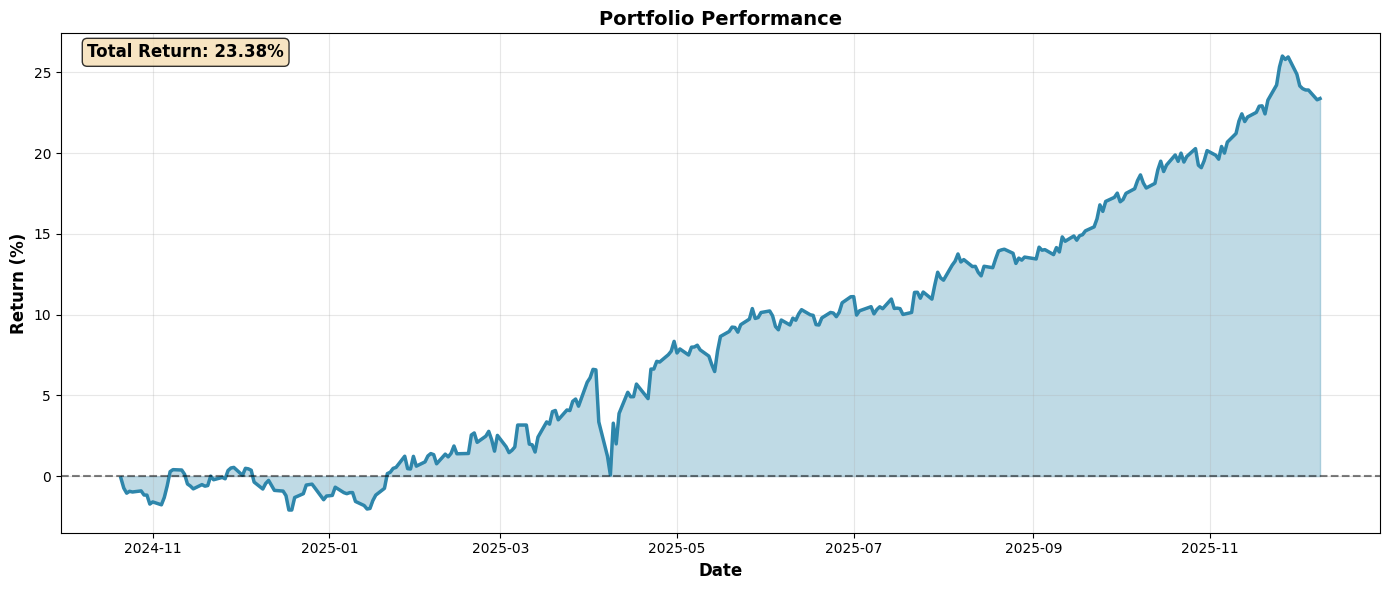

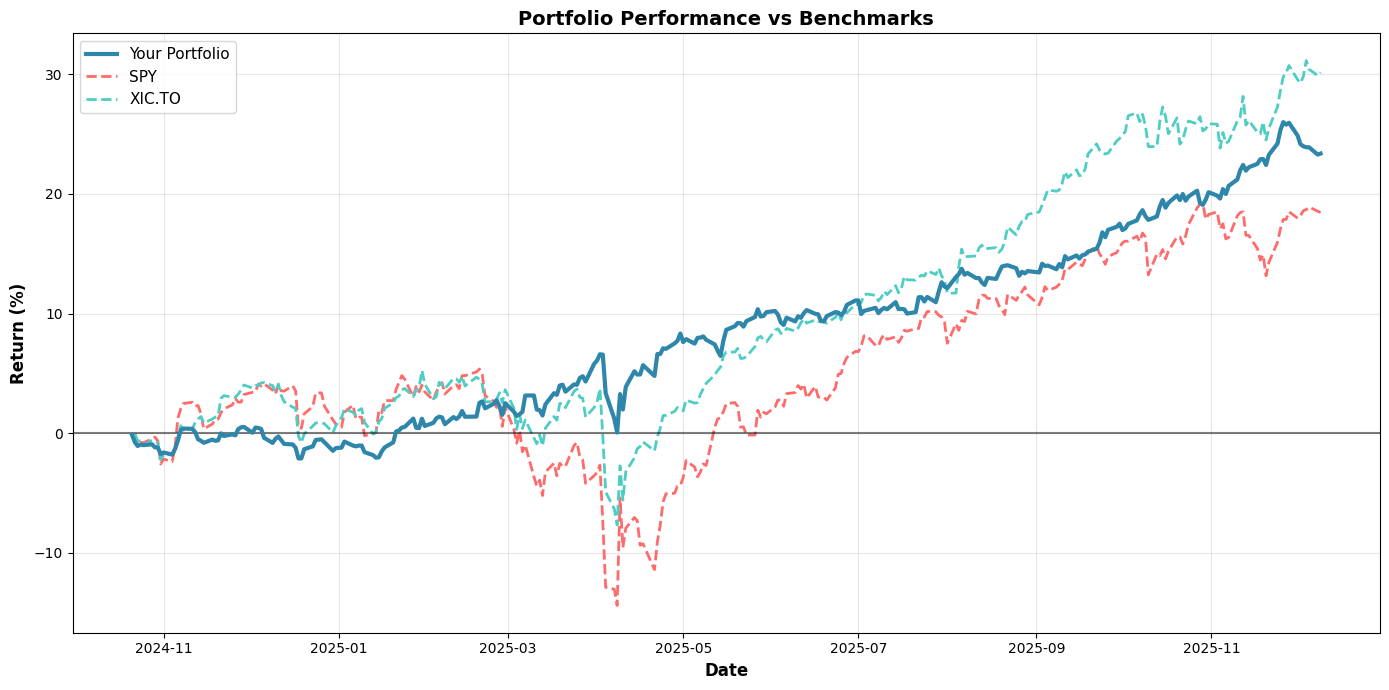

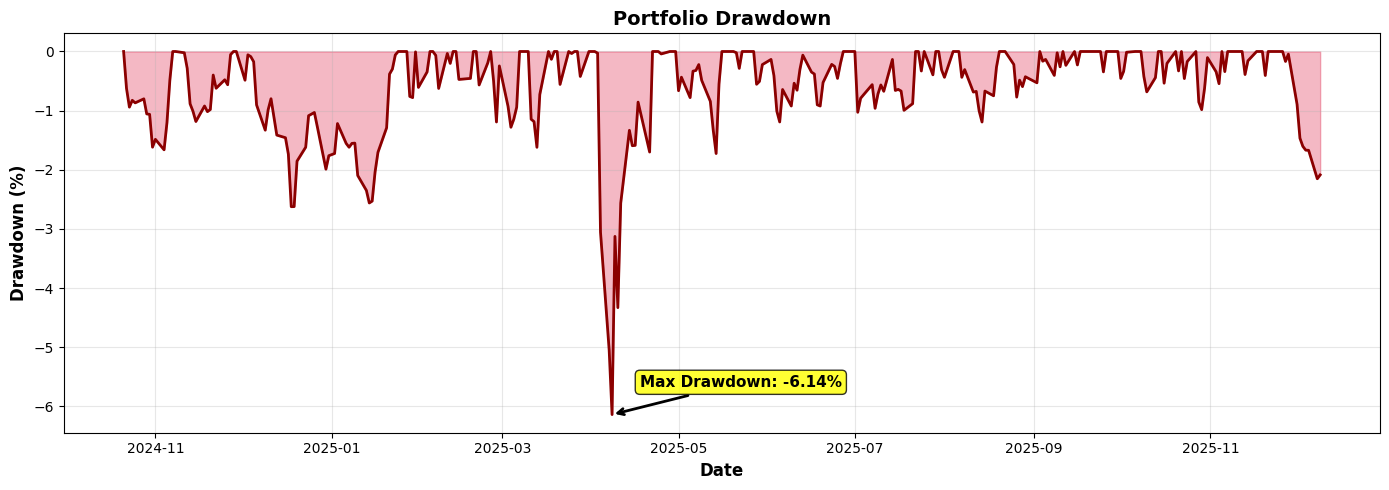

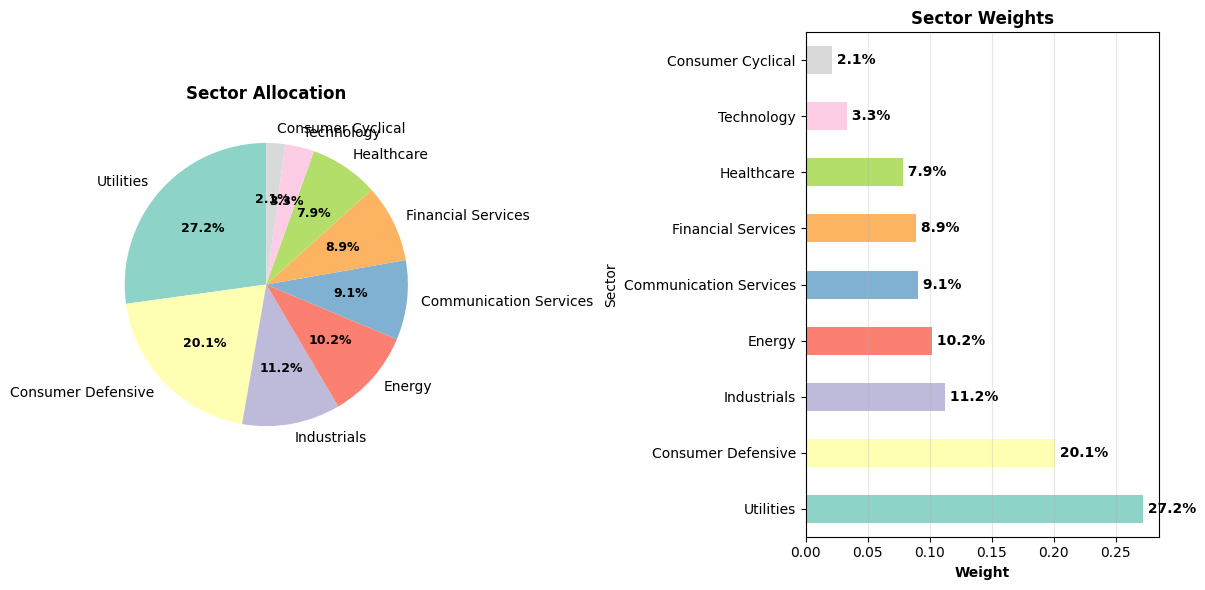

In [209]:
results = analyze_portfolio(Portfolio_Final, "2023-01-01", "2025-12-10", all_tickers_df)